# DESI Instrument Throughput

The purpose of this notebook is to document the contents and creation of the following files in `desimodel/data/throughput/` files that describe the instrument throughput, and are based on [DESI-0347-v10](https://desi.lbl.gov/DocDB/cgi-bin/private/ShowDocument?docid=347):
* `DESI-0347_blur.ecsv`: RMS spot radius as a function of wavelength and field angle.
* `DESI-0347_offset.ecsv`: Centroid lateral offset as a function of wavelength and field angle.
* `DESI-0347_random_offset_<n>.fits`: Random realization of centroid offsets using seeds n=1,2,3.

### Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import os.path
import re

In [3]:
import astropy.table
import astropy.units as u
from astropy.io import fits
from astropy import wcs

## Preprocess Ray Tracing Results

Read the original ray tracing results into numpy arrays. These results are from Mike Sholl and used to create the pasted plot in the geometric_blur tab of the the DESI-0347 spreadsheet (after replacing a non-standard \mu encoding with 'u'). The format of the original file is not well suited for machine reading, so we provide code below to write more suitable outputs.  The file is read from `$DESIMODEL/data/inputs/throughput/raytracing.txt` and requires that `$DESIMODEL` is set.

In [4]:
def read_raytracing(num_sections=14, num_groups=12):
    
    # Initialize the result arrays.
    wavelength = np.zeros(num_sections)
    band_size = np.zeros(num_sections)
    field_angle = np.empty(num_groups)
    spot_centroid = np.empty((num_sections, num_groups, 2))
    rms_spot_radius = np.empty((num_sections, num_groups))
    rms_spot_size = np.empty((num_sections, num_groups, 2))
    
    # Read the file into memory.
    filename = os.path.join(os.environ['DESIMODEL'],
                            'data', 'inputs', 'throughput', 'raytracing.txt')
    with open(filename, 'r') as f:
        lines = f.readlines()
    print('Read {0} lines from {1}.'.format(len(lines), filename))
    
    for section in range(num_sections):
        i = 86 * section
        # First two section headers are "Whole band", "360-375nm".
        # Remaining headers have the form: 360-400 band
        section_header = lines[i].rstrip()
        if section > 0:
            wlen_lo, wlen_hi = float(section_header[:3]), float(section_header[4:7])
            wavelength[section] = 0.5 * (wlen_lo + wlen_hi)
            band_size[section] = wlen_hi - wlen_lo
        for group in range(num_groups):
            j = i + 7 * group + 2
            # Extract the field angle [deg] from a line of the form:
            # Field coordinate  :  0.00000000E+000  4.50000000E-001
            fa = float(lines[j].rstrip().split()[-1])
            if section == 0:
                field_angle[group] = fa
            else:
                assert field_angle[group] == fa
            # Extract the spot centroid [mm] from a line of the form:
            # Image coordinate  : -1.01677290E-014  1.09734671E+002
            spot_centroid[section, group, :] = map(float, lines[j + 1].split()[-2:])
            # Extract the RMS spot radius from a line of the form:
            # RMS Spot Radius   :  1.91079098E+001 µm
            rms_spot_radius[section, group] = float(lines[j+2].split()[-2])
            # Extract the RMS spot X, Y sizes from lines of the form:
            # RMS Spot X Size   :  1.06094918E+001 µm
            rms_spot_size[section, group, 0] = float(lines[j+3].split()[-2])
            rms_spot_size[section, group, 1] = float(lines[j+4].split()[-2])
            
    # Apply units.
    wavelength = wavelength * u.nm
    band_size = band_size * u.nm
    field_angle = field_angle * u.deg
    spot_centroid = spot_centroid * u.mm
    rms_spot_radius = rms_spot_radius * u.um
    rms_spot_size = rms_spot_size * u.um

    return wavelength, band_size, field_angle, spot_centroid, rms_spot_radius, rms_spot_size

wavelength, band_size, field_angle, \
spot_centroid, rms_spot_radius, rms_spot_size = read_raytracing()

Read 1203 lines from /Users/david/Cosmo/DESI/code/desimodel-git/data/inputs/throughput/raytracing.txt.


Reproduce the plot on the geometric_blur tab of the DESI-0347-v10 spreadsheet. For reference, the fiber diameter is 107.0um.

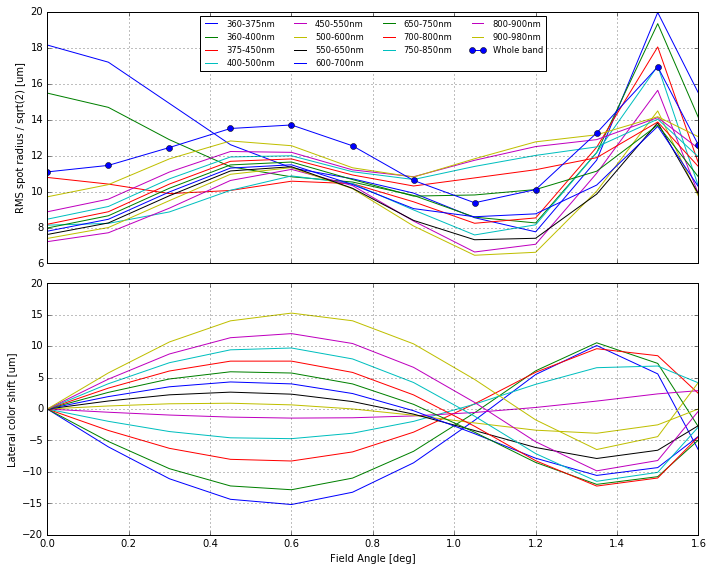

In [5]:
def plot_raytracing(wavelength, band_size, field_angle, spot_centroid, rms_spot_radius,
                    rms_spot_size, save=None):

    nwlen, npos = rms_spot_radius.shape[:2]
    angle = field_angle.to(u.deg).value
    
    # Initialize plot.
    fig, (top, btm) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    for i in range(1, nwlen):
        lo = (wavelength[i] - 0.5 * band_size[i]).to(u.nm).value
        hi = (wavelength[i] + 0.5 * band_size[i]).to(u.nm).value
        label = '{:.0f}-{:.0f}nm'.format(lo, hi)
        top.plot(angle, rms_spot_radius[i].to(u.um).value / np.sqrt(2), label=label)
        btm.plot(angle, (spot_centroid[i, :, 1] - spot_centroid[0, :, 1])
                 .to(u.um).value, label=label)
    
    top.plot(angle, rms_spot_radius[0].to(u.um).value / np.sqrt(2),
             'bo-', label='Whole band')
    top.legend(bbox_to_anchor=(0.5, 1), loc='upper center',
               ncol=nwlen // 3, fontsize='small')
    top.set_ylabel('RMS spot radius / sqrt(2) [um]')
    top.set_ylim(6., 20.)
    top.grid()
    btm.set_xlabel('Field Angle [deg]')
    btm.set_ylabel('Lateral color shift [um]')
    btm.set_ylim(-20, +20)
    btm.set_xlim(0., 1.6)
    btm.grid()
    plt.tight_layout()
    if save:
        plt.savefig(save)

plot_raytracing(wavelength, band_size, field_angle, spot_centroid,
                rms_spot_radius, rms_spot_size, save='raytracing.png')

## Throughput Spreadsheet Data

In this section, we copy some numbers needed below from the Throughput sheet of DESI-0347. The current version is v10, but one of the files now in desimodel (`DESI-0347-throughput.txt`) is based on v5 numbers so we include that also.

Calculate the achromatic blur as the quadrature sum of cells B43:B72 of the throughput sheet in DESI-0347:

In [6]:
def get_achromatic_blur(version='v10'):
    if version == 'v10':
        # Achromatic offset contributions from cells B43:B72 of the throughput sheet.
        achromatic_blur = np.array([
            7.629, 2.431, 1.049, 0.667, 0.000, 0.000, 0.001,
            0.422, 0.205, 0.400, 1.561, 4.035]) * u.um
    elif version == 'v5':
        achromatic_blur = np.array([
            7.629, 2.431, 1.049, 0.667, 0.000, 0.000, 0.001,
            0.422, 0.205, 0.400, 1.561, 4.760]) * u.um
    else:
        raise ValueError('Invalid version: {0}.'.format(version))
    return np.sqrt(np.sum(achromatic_blur ** 2))

Calculate the achromatic RMS centroid offset to generate, as the quadrature sum of cells B43:B72 of the throughput sheet of DESI-0347.  The values changed significantly between v5 and v10, which is significant because v5 was used to generate `desimodel/data/inputs/DESI-0347-throughput.txt`, which is used for the validation below.  The main change in v10 is the addition of an 8um error in cell B50 for the "FVC corrector optics figure error", based on DESI-1071.

The latest revision (v2 May 2016) of DESI-1071 increases this value from 8um to 9um. However, this is not reflected in the latest DESI-0347-v10 and probably will not be.  Bobby Besuner writes:
```
You are correct that if we are referencing DESI-1071, we should use the 9um value given there.

We can make that change now, but we will be updating that value when we get as-built measurements of the lenses from the manufacturers, and if the lenses meet spec's, we expect they will be at least somewhat better than the specifications.

I'm not sure it's worth rolling the revision of 347 just for that one micron change in one item, which is almost sure to change (hopefully for the better) once all the lenses have been finished and measured.
```

In [7]:
def get_achromatic_rms_offset(version='v10'):
    if version == 'v10':
        # Achromatic offset contributions from cells B43:B72 of the throughput sheet.
        achromatic_offsets = np.array([
            0.000, 0.000, 4.000, 0.000, 2.000, 2.000, 3.000, 8.000, 1.000, 2.000,
            2.000, 1.500, 2.000, 1.500, 1.420, 0.110, 0.090, 0.000, 0.400, 0.090,
            0.062, 1.173, 0.002, 0.006, 0.195, 0.030, 0.012, 0.391, 0.469]) * u.um
    elif version == 'v5':
        achromatic_offsets = np.array([
            0.000, 0.000, 4.000, 0.000, 2.000, 2.000, 3.000, 2.000, 2.000, 1.500,
            2.000, 1.000, 1.420, 0.110, 0.090, 0.000, 0.400, 0.090, 0.062, 1.173,
            0.002, 0.006, 0.195, 0.030, 0.012, 0.391, 0.469]) * u.um
    else:
        raise ValueError('Invalid version: {0}.'.format(version))
    return np.sqrt(np.sum(achromatic_offsets ** 2))

Summarize the quadrature sums we need below:

In [8]:
def summarize():
    t = astropy.table.Table();
    t['Version'] = ['v5', 'v10']
    t['Blur'] = astropy.table.Column([
            get_achromatic_blur('v5').to(u.um).value,
            get_achromatic_blur('v10').to(u.um).value] * u.um,
            format='{:.3f}')
    t['Offset'] = astropy.table.Column([
            get_achromatic_rms_offset('v5').to(u.um).value,
            get_achromatic_rms_offset('v10').to(u.um).value] * u.um,
            format='{:.3f}')
    print(t)
    
summarize()

Version  Blur Offset
          um    um  
------- ----- ------
     v5 9.546  7.228
    v10 9.206 10.886


## Write Throughput Output Files

The functions below write files into the current directory with extensions .ecsv and .fits.  These should be copied into `$DESIMODEL/data/throughput/` after any updates.

### Extrapolation

The ray tracing results above span 3675 - 9400 A, but we need to cover 3550 - 9850 A for simulations so we lienarly extrapolate one extra point at each end.  This implementation does not use any external library and works with optional units.

In [9]:
def extrapolate(x_in, y_in, x_lo, x_hi):
    
    assert x_in.shape == y_in.shape
    
    try:
        x_unit = x_in.unit
    except AttributeError:
        x_unit = 1
    try:
        y_unit = y_in.unit
    except AttributeError:
        y_unit = 1
        
    dx = x_in[1:] - x_in[:-1]
    dy = y_in[1:] - y_in[:-1]
    y_lo = y_in[0] + dy[0] / dx[0] * (x_lo - x_in[0])
    y_hi = y_in[-1] + dy[-1] / dx[-1] * (x_hi - x_in[-1])
    
    x_out = np.hstack(
        (x_lo.to(x_unit).value,
         x_in.to(x_unit).value,
         x_hi.to(x_unit).value)) * x_unit
    y_out = np.hstack(
        (y_lo.to(y_unit).value,
         y_in.to(y_unit).value,
         y_hi.to(y_unit).value)) * y_unit

    return x_out, y_out

### Spot Radius

Write RMS spot radius values (aka "blur") to an ECSV file. See the description embedded in the code for more details.

In [10]:
def save_blur(wavelength, field_angle, raytracing_blur,
              wlen_lo=355*u.nm, wlen_hi=985*u.nm,
              filename='DESI-0347_blur.ecsv'):
    
    description = """\
RMS spot size as a function of wavelength and field angle derived from \
DESI-0347-v10. Chromatic contributions are based on a text file prepared \
by Mike Sholl that is also plotted in the geometric_blur tab of the \
throughput spreadsheet in DESI-0347-v10. Achromatic contributions are taken \
from cells B14:B26 added in quadrature."""
    table = astropy.table.Table(meta=dict(description=description))
    
    # Add wavelength points at each end.
    wlen_ext, _ = extrapolate(wavelength, raytracing_blur[:, 0], wlen_lo, wlen_hi)
    
    # Convert wavelength values from nm to Angstrom.
    table['wavelength'] = astropy.table.Column(
        wlen_ext, unit='Angstrom', format='{:.1f}',
        description='Wavelength')
    
    for i, r in enumerate(field_angle):
        column_name = 'r={0:.2f}'.format(r)
        # Extrapolate values at each end.
        _, blur_ext = extrapolate(wavelength, raytracing_blur[:, i], wlen_lo, wlen_hi)
        # Add achromatic blur in quadrature.
        blur = np.sqrt(blur_ext ** 2 + get_achromatic_blur() ** 2)
        table[column_name] = astropy.table.Column(
            blur, unit='micron', format='{:.4f}',
            description='RMS spot size at field angle {0}.'.format(column_name))

    table.write(filename, format='ascii.ecsv')

save_blur(wavelength[1:], field_angle, rms_spot_radius[1:] / np.sqrt(2))

### Centroid Offset

We split centroid offsets into two components: one based on ray tracing of the ideal optics, which depends on wavelength and field angle, and one based on expected random and systematic errors which depends on the 2D focal plane position but is independent of wavelength.

Write ray tracing centroid offset values, which are purely radial, to an ECSV file. See the description embedded in the code for more details.

In [11]:
def save_offset(wavelength, field_angle, raytracing_offset,
                wlen_lo=355*u.nm, wlen_hi=985*u.nm,
                filename='DESI-0347_offset.ecsv'):
    
    description = """\
Radial centroid offset as a function of wavelength and field angle derived \
from DESI-0347-v10. Values are based on a text file prepared \
by Mike Sholl that is also plotted in the geometric_blur tab of the \
throughput spreadsheet in DESI-0347-v10.  Values are derived from ray \
tracing of the ideal optics and do not include the random achromatic \
errors in cells B43:B72 of the throughput sheet."""
    table = astropy.table.Table(meta=dict(description=description))
    
    # Add wavelength points at each end.
    wlen_ext, _ = extrapolate(wavelength, raytracing_offset[:, 0], wlen_lo, wlen_hi)
    
    table['wavelength'] = astropy.table.Column(
        wlen_ext, unit='Angstrom', format='{:.1f}',
        description='Center of wavelength band')
    
    for i, r in enumerate(field_angle):
        column_name = 'r={0:.2f}'.format(r)
        # Extrapolate values at each end.
        _, offset_ext = extrapolate(wavelength, raytracing_offset[:, i], wlen_lo, wlen_hi)
        table[column_name] = astropy.table.Column(
            offset_ext, unit='micron', format='{:.4f}',
            description='Radial centroid offset at field angle {0}.'.format(column_name))

    table.write(filename, format='ascii.ecsv')

save_offset(wavelength[1:], field_angle, spot_centroid[1:, :, 1] - spot_centroid[0, :, 1])

Generate and save random offsets with an RMS equal to the quadrature sum of achromatic terms in the throughput spreadsheet. Uses new code in `desimodel.focalplane` for the random generation.

In [12]:
def save_random_offsets(seed=1, fov=3.2 * u.deg):

    # Generate random dx, dy offsets on a square grid.
    import desimodel.focalplane
    dx, dy = desimodel.focalplane.generate_random_centroid_offsets(seed=seed)
    npix = len(dx)
    scale = fov.to(u.deg).value / npix
    
    # Save offsets to a FITS file. HDU0 just has a header.
    header = fits.Header()
    header['COMMENT'] = 'Random focal plane centroid offsets in microns.'
    header['SEED'] = seed
    hdu0 = fits.PrimaryHDU(header=header)
    
    # HDU1, 2 contain dx, dy offsets in microns as 2D image data.
    w = wcs.WCS(naxis=2)
    w.wcs.ctype = ['x', 'y']
    w.wcs.crpix = [npix / 2. + 0.5, npix / 2. + 0.5]
    w.wcs.cdelt = [scale, scale]
    w.wcs.crval = [0., 0.]
    header = w.to_header()
    header['BUNIT'] = 'um'
    header['COMMENT'] = '+x component of focal plane offset.'
    hdu1 = fits.ImageHDU(data=dx.to(u.um).value.astype(np.float32),
                         name='XOFFSET', header=header)
    header['COMMENT'] = '+y component of focal plane offset.'
    hdu2 = fits.ImageHDU(data=dy.to(u.um).value.astype(np.float32),
                         name='YOFFSET', header=header)
    
    hdus = fits.HDUList([hdu0, hdu1, hdu2])
    hdus.writeto('DESI-0347_random_offset_{0}.fits'.format(seed), clobber=True)

In [13]:
save_random_offsets(seed=1)
save_random_offsets(seed=2)
save_random_offsets(seed=3)

## Validation

Define a helper function to parse a string as numeric quantity with units.  This is a copy of `specsim.config.parse_quantity()` to avoid adding a specsim dependency.

In [14]:
def parse_quantity(string, dimensions=None):
    _float_pattern = re.compile(
        '\s*([-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?)\s*')
    # Look for a valid number starting the string.
    found_number = _float_pattern.match(string)
    if not found_number:
        raise ValueError('Unable to parse quantity.')
    value = float(found_number.group(1))
    unit = string[found_number.end():]
    quantity = astropy.units.Quantity(value, unit)
    if dimensions is not None:
        try:
            if not isinstance(dimensions, astropy.units.Unit):
                dimensions = astropy.units.Unit(dimensions)
            quantity = quantity.to(dimensions)
        except (ValueError, astropy.units.UnitConversionError):
            raise ValueError('Quantity "{0}" is not convertible to {1}.'
                             .format(string, dimensions))
    return quantity

Define a function that can read either of the ECSV files created above and decode the field angles from the column names.

In [15]:
def load_table_2d(filename, x_column_name, y_column_prefix):

    table = astropy.table.Table.read(filename, format='ascii.ecsv')
    nx = len(table)
    x = table[x_column_name].copy()
    
    # Look for columns whose name has the specified prefix.
    y_value, y_index = [], []
    y_unit, data_unit = 1, 1
    for i, colname in enumerate(table.colnames):
        if colname.startswith(y_column_prefix):
            # Parse the column name as a value.
            y = parse_quantity(colname[len(y_column_prefix):])
            if y_unit == 1:
                y_unit = y.unit
            elif y_unit != y.unit:
                raise RuntimeError('Column unit mismatch: {0} != {1}.'
                                   .format(y_unit, y.unit))
            if data_unit == 1:
                data_unit = table[colname].unit
            elif data_unit != table[colname].unit:
                raise RuntimeError('Data unit mismatch: {0} != {1}.'
                                   .format(data_unit, table[colname].unit))
            y_value.append(y.value)
            y_index.append(i)

    # Prepare the array of y values.
    ny = len(y_value)
    y = np.array(y_value) * y_unit
    
    # Extract values for each x,y pair.
    data = np.empty((nx, ny))
    for j, i in enumerate(y_index):
        data[:, j] = table.columns[i][:]
        
    return x, y, data * data_unit

Read a random centroid offsets file and plot a subset of them as a vector field.

In [16]:
def plot_random_offsets(seed=1, subsampling=4, save=None):

    hdus = fits.open('DESI-0347_random_offset_{0}.fits'.format(seed))

    # Extract the offset images.
    dx = hdus['XOFFSET'].data
    dy = hdus['YOFFSET'].data
    dr = np.sqrt(dx ** 2 + dy ** 2)
    
    # Reconstruct the linear WCS.
    hdr = hdus[1].header
    w = wcs.WCS(hdr)
    nxy = len(dx)
    pix = np.arange(nxy)
    xlo, ylo, xhi, yhi = w.wcs_pix2world([[0, 0], [nxy - 1, nxy - 1]], 0).flatten()
    assert xlo == ylo and xhi == yhi
    xy = np.linspace(xlo, xhi, nxy)
    xy_pad = hdr['CDELT1']
    unit = u.Unit(hdr['BUNIT'])
    
    # Downsample.
    dx = dx[::subsampling, ::subsampling]
    dy = dy[::subsampling, ::subsampling]
    dr = dr[::subsampling, ::subsampling]
    xy = xy[::subsampling]

    plt.figure(figsize=(12, 10))
    plt.quiver(xy, xy, dx, dy, dr, headwidth=1.5, headlength=2.)
    plt.xlim(xy[0] - xy_pad, xy[-1] + xy_pad)
    plt.ylim(xy[0] - xy_pad, xy[-1] + xy_pad)
    plt.xlabel('x-offset from plate center [deg]')
    plt.ylabel('y-offset from plate center [deg]')
    plt.gca().set_aspect(1)
    plt.colorbar(pad=0.01, shrink=0.95).set_label(
        'Centroid offset [{0}]'.format(unit))
    plt.tight_layout()
    if save:
        plt.savefig(save)

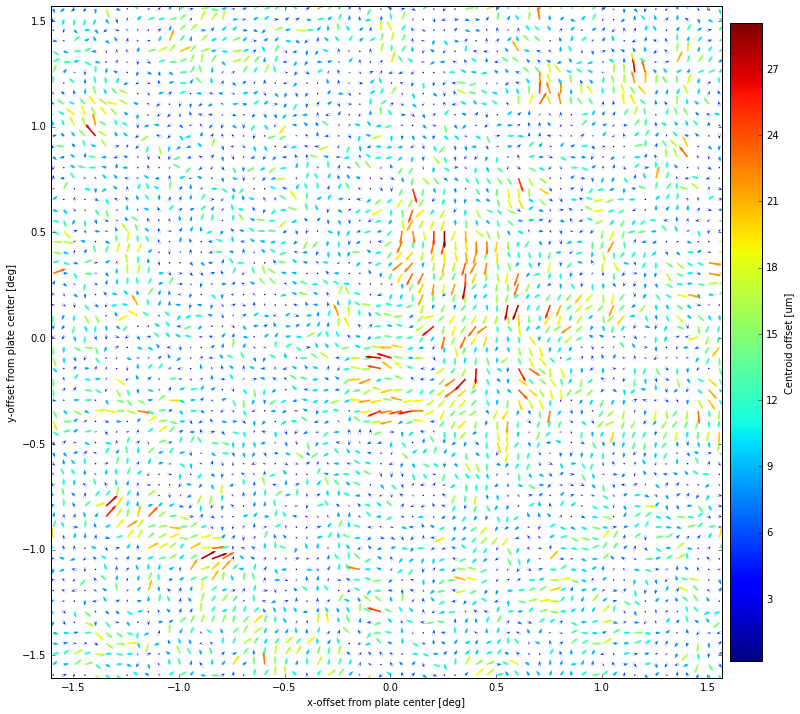

In [17]:
plot_random_offsets(2, save='random_offset_2.png')

Load the contents of `$DESIMODEL/data/inputs/throughputs/DESI-0347-throughput.txt`, which contains blur and offset values averaged over field angles.  The inputs and code used to create this file are no longer available, but we need to check that the new files we are writing are consistent with this earlier file.  This function requires that `$DESIMODEL` is set.

In [18]:
def load_throughput():
    name = os.path.join(os.environ['DESIMODEL'], 'data', 'inputs',
                        'throughput', 'DESI-0347-throughput.txt')
    table = astropy.table.Table.read(name, format='ascii',
                                     names=('wlen', 'sky_thru', 'ins_thru', 'offset', 'blur'))
    table['wlen'].unit = u.nm
    table['offset'].unit = u.um
    table['blur'].unit = u.um
    return table

Plot a comparison of `DESI-0347-throughput.txt` quantities with equivalent field-angle-averaged quantities derived from the new output files.  Since `DESI-0347-throughput.txt` was derived from v5 of DESI-0347, we also compare RMS offsets between v5 and v10. For reference, the fiber diameter is 107.0um.  The blur and offset ECSV files are read from the current directory and not `$DESIMODEL/data`.

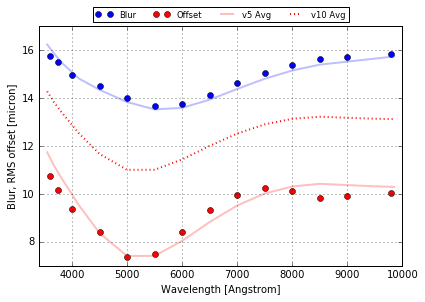

In [19]:
def plot_validation(wgt_exp=1.0, save=None):
    
    # Load the original throughput data.
    thru = load_throughput()
    
    # Load the new blur and offset data.
    wlen, fangle, blur = load_table_2d('DESI-0347_blur.ecsv', 'wavelength', 'r=')
    wlen, fangle, offset = load_table_2d('DESI-0347_offset.ecsv', 'wavelength', 'r=')

    # Get the DESI-0347 achromatic centroid offsets in v5 and v10.
    offset_rms_v5 = get_achromatic_rms_offset(version='v5')
    offset_rms_v10 = get_achromatic_rms_offset(version='v10')
    
    # Calculate field-angle-weighted averages, to account for the larger number of targets
    # at larger field angles.
    wgt = fangle.value ** wgt_exp
    wgt_sum = np.sum(wgt)
    weighted_mean = lambda x: np.sum(wgt * x, axis=1) / wgt_sum
    weighted_rms = lambda x: np.sqrt(
        np.sum(wgt * x ** 2, axis=-1) * wgt_sum - np.sum(wgt * x, axis=-1) ** 2) / wgt_sum
    
    avg_blur = weighted_mean(blur)
    avg_offset_v5 = np.sqrt(weighted_rms(offset) ** 2 + offset_rms_v5 ** 2)
    avg_offset_v10 = np.sqrt(weighted_rms(offset) ** 2 + offset_rms_v10 ** 2)
    
    # Plot the original throughput data.
    plt.plot(thru['wlen'].to(u.Angstrom).value,
             thru['blur'].to(u.um).value, 'bo', label='Blur')
    plt.plot(thru['wlen'].to(u.Angstrom).value,
             thru['offset'].to(u.um).value, 'ro', label='Offset')
    
    # Plot the new field-angle-weighted throughput data.
    plt.plot(wlen.to(u.Angstrom).value,
             avg_blur.to(u.um).value, 'b-', lw=2, alpha=0.25)
    plt.plot(wlen.to(u.Angstrom).value,
             avg_offset_v5.to(u.um).value, 'r-', lw=2, alpha=0.25, label='v5 Avg')
    plt.plot(wlen.to(u.Angstrom).value,
             avg_offset_v10.to(u.um).value, 'r:', lw=2, label='v10 Avg')

    plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center',
               ncol=4, fontsize='small')
    plt.xlabel('Wavelength [Angstrom]')
    plt.ylabel('Blur, RMS offset [micron]')
    plt.xlim(3400, 10000)
    plt.grid()

    plt.tight_layout()
    if save:
        plt.savefig(save)
    
plot_validation(save='validation.png')